# Gold Prediction Project

This notebook will use three different machine learning models to predict a signal that indicates whether to buy gold or not. While not entirely original, this project builds upon a similar idea to [Stock Price Prediction using Machine Learning in Python](https://www.geeksforgeeks.org/stock-price-prediction-using-machine-learning-in-python/).

## Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Import Gold Data

In [2]:
df = pd.read_csv('gold prices.csv')
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,08/17/2023,1915.2,146770.0,1922.4,1933.5,1914.2
1,08/16/2023,1928.3,124766.0,1933.1,1938.2,1922.0
2,08/15/2023,1935.2,161512.0,1939.4,1944.3,1927.5
3,08/14/2023,1944.0,117514.0,1945.6,1948.2,1934.2
4,08/11/2023,1946.6,119090.0,1944.9,1953.6,1942.7


## Exploratory Data Analysis

In [3]:
df.rename(columns={'Close/Last': 'Close'}, inplace=True)

In [4]:
df.describe()

,Close,Volume,Open,High,Low
count,2539.000000,2511.000000,2539.000000,2539.000000,2539.000000
mean,1467.437456,183765.289128,1467.455967,1477.035880,1457.630721
std,282.891621,98028.942525,283.126968,285.232942,280.366732
min,1049.600000,1.000000,1051.500000,1062.700000,1045.400000
25%,1243.900000,123166.500000,1243.850000,1251.250000,1235.800000
50%,1321.400000,172127.000000,1321.700000,1329.300000,1314.000000
75%,1774.050000,233415.000000,1773.950000,1785.000000,1763.550000
max,2069.400000,787217.000000,2076.400000,2085.400000,2049.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2539 entries, 0 to 2538
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2539 non-null   object 
 1   Close   2539 non-null   float64
 2   Volume  2511 non-null   float64
 3   Open    2539 non-null   float64
 4   High    2539 non-null   float64
 5   Low     2539 non-null   float64
dtypes: float64(5), object(1)
memory usage: 119.1+ KB


In [6]:
df.isnull().sum()

Date       0
Close      0
Volume    28
Open       0
High       0
Low        0
dtype: int64

Not a lot of NULL values in the dataset. Dropping these values from the dataset would not be an issue.

In [7]:
df.dropna(inplace = True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.isnull().sum()

Date      0
Close     0
Volume    0
Open      0
High      0
Low       0
dtype: int64

In [9]:
df.duplicated().sum()

0

Checking to see if there are any duplicated values/rows and it seems that there aren't any in this dataset.

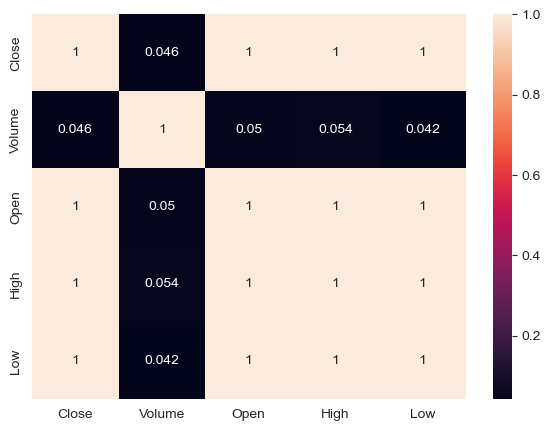

In [10]:
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(),annot=True);

The "Low", "High", "Open", and "Close" variables are very highly correlated with one another. The Volume variable doesn't seem to be correlated with the rest of the variables.

In [11]:
df['Date'] = pd.to_datetime(df['Date'])

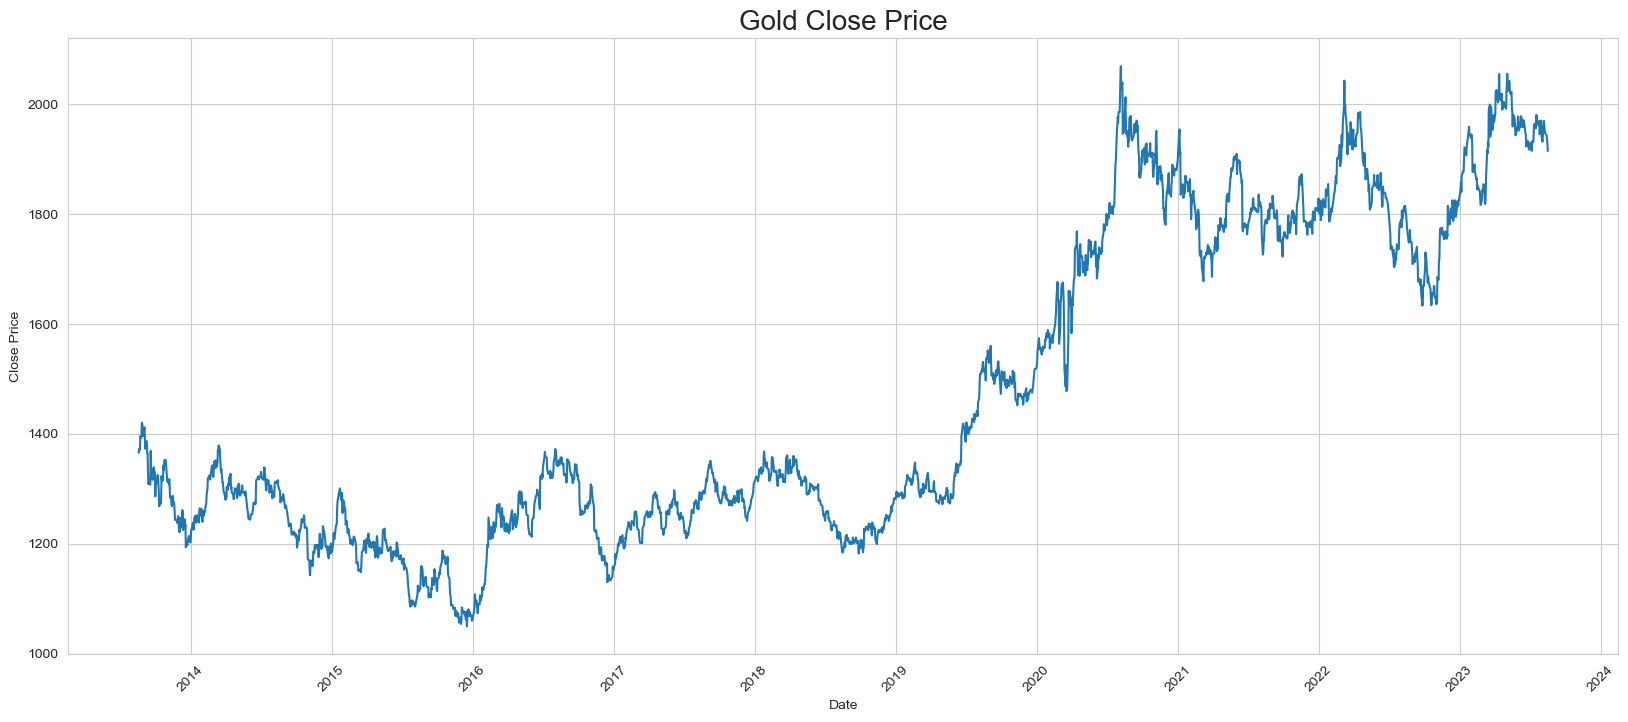

In [12]:
plt.figure(figsize=(20,8))
plt.plot('Date','Close',data=df)
plt.title('Gold Close Price', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45);

Based on this plot of the closing price, it can be seen that the prices of gold are showing an upward trend. 

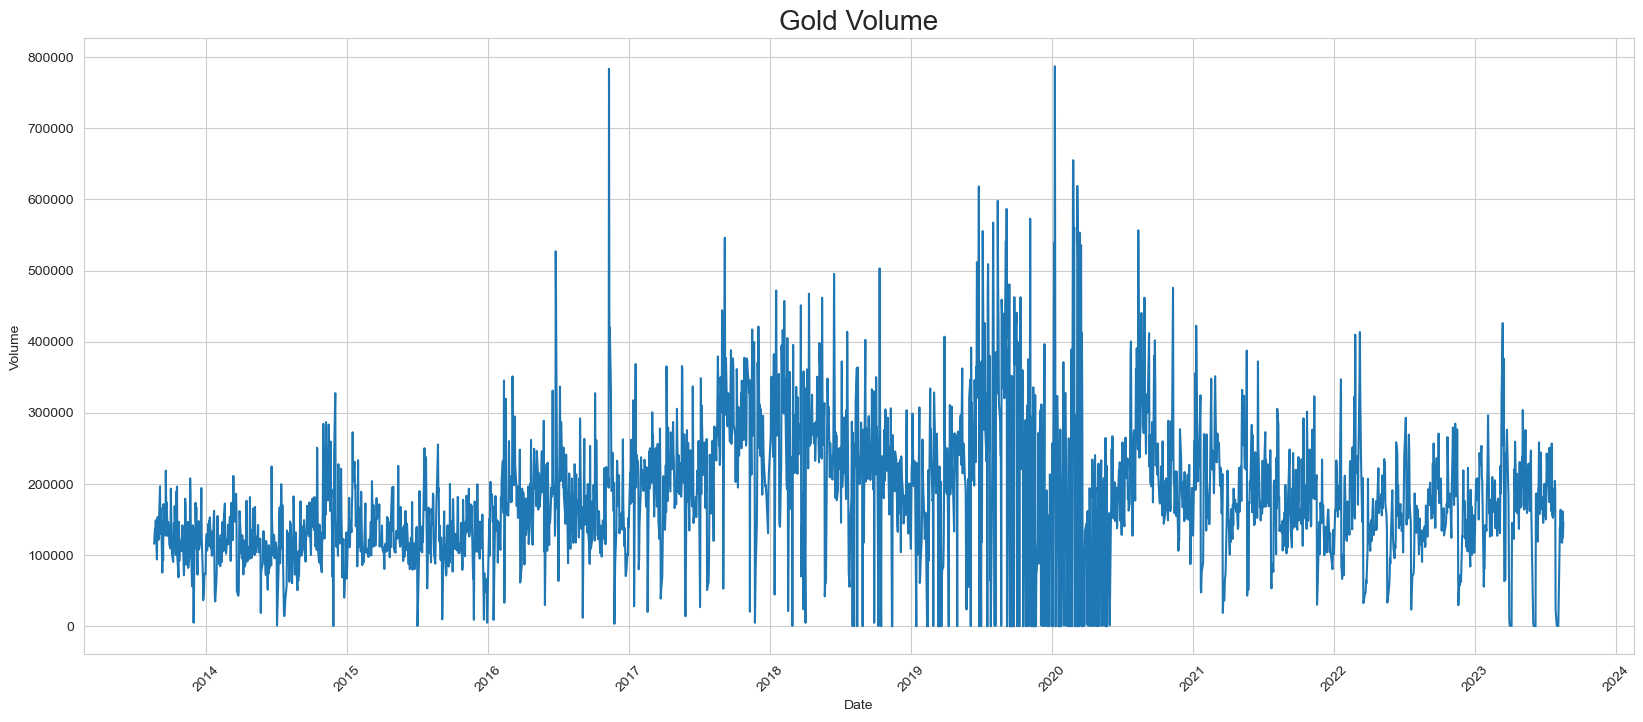

In [13]:
plt.figure(figsize=(20,8))
plt.plot('Date','Volume',data=df)
plt.title('Gold Volume', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45);

Volume is the overall sum of all transactions executed in the market during a given period of time (roughly 10 years in this dataset), which shows market power. Looking at this plot, there appear to be two peaks in late 2016 and early 2020.

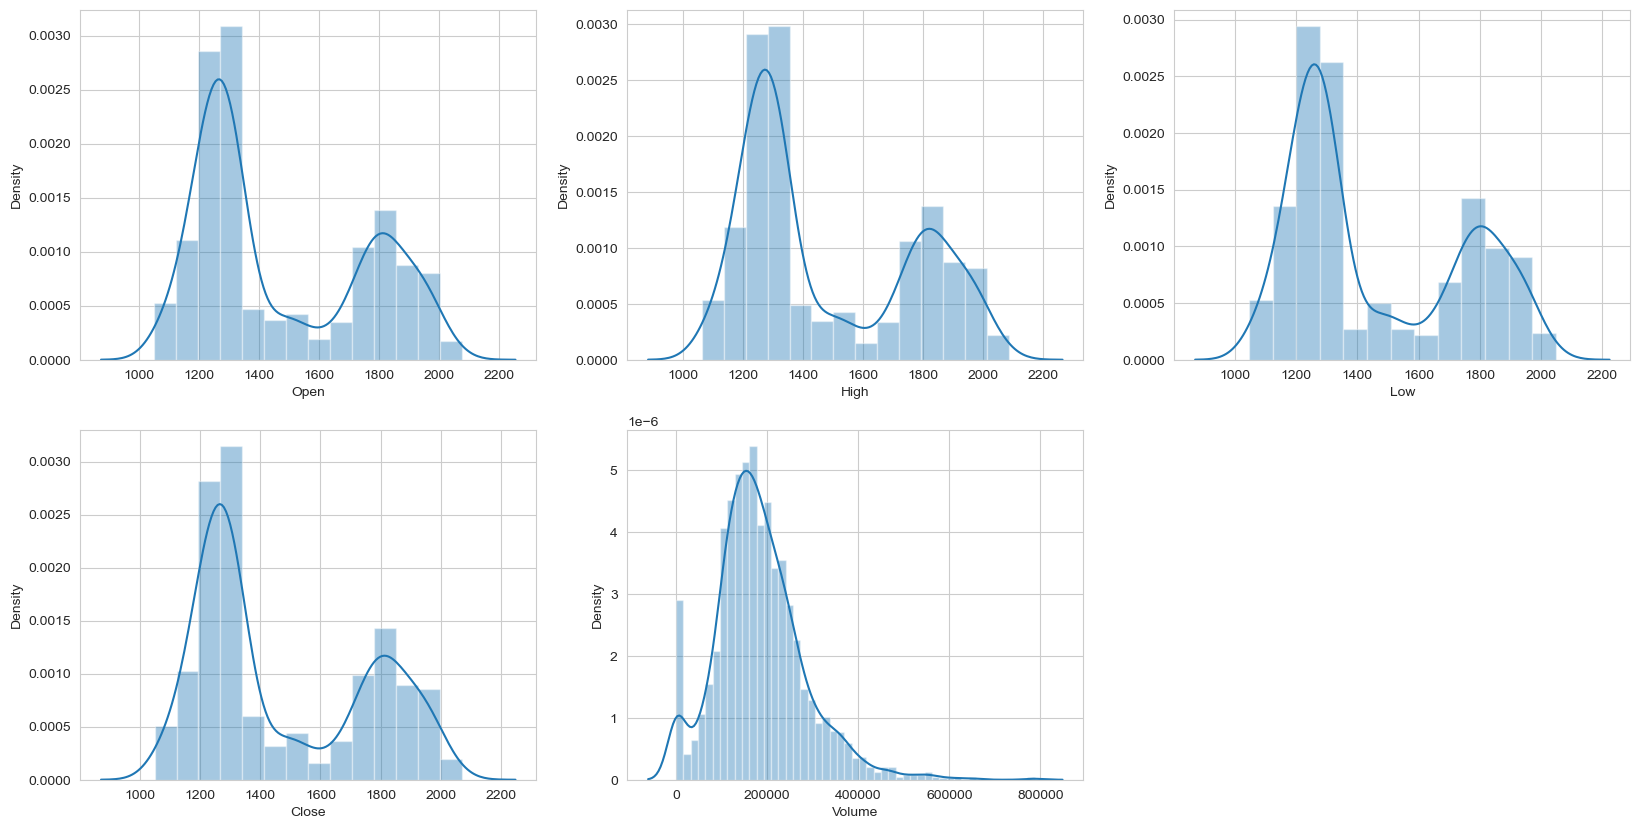

In [14]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.distplot(df[col])
plt.show()

In the distribution plots of the "Open", "High", "Low", and "Close" variables, it can be seen that there are two peaks. This means that the data has altered remarkably in two regions. It can also be seen that the "Volume" dataset is left-skewed.

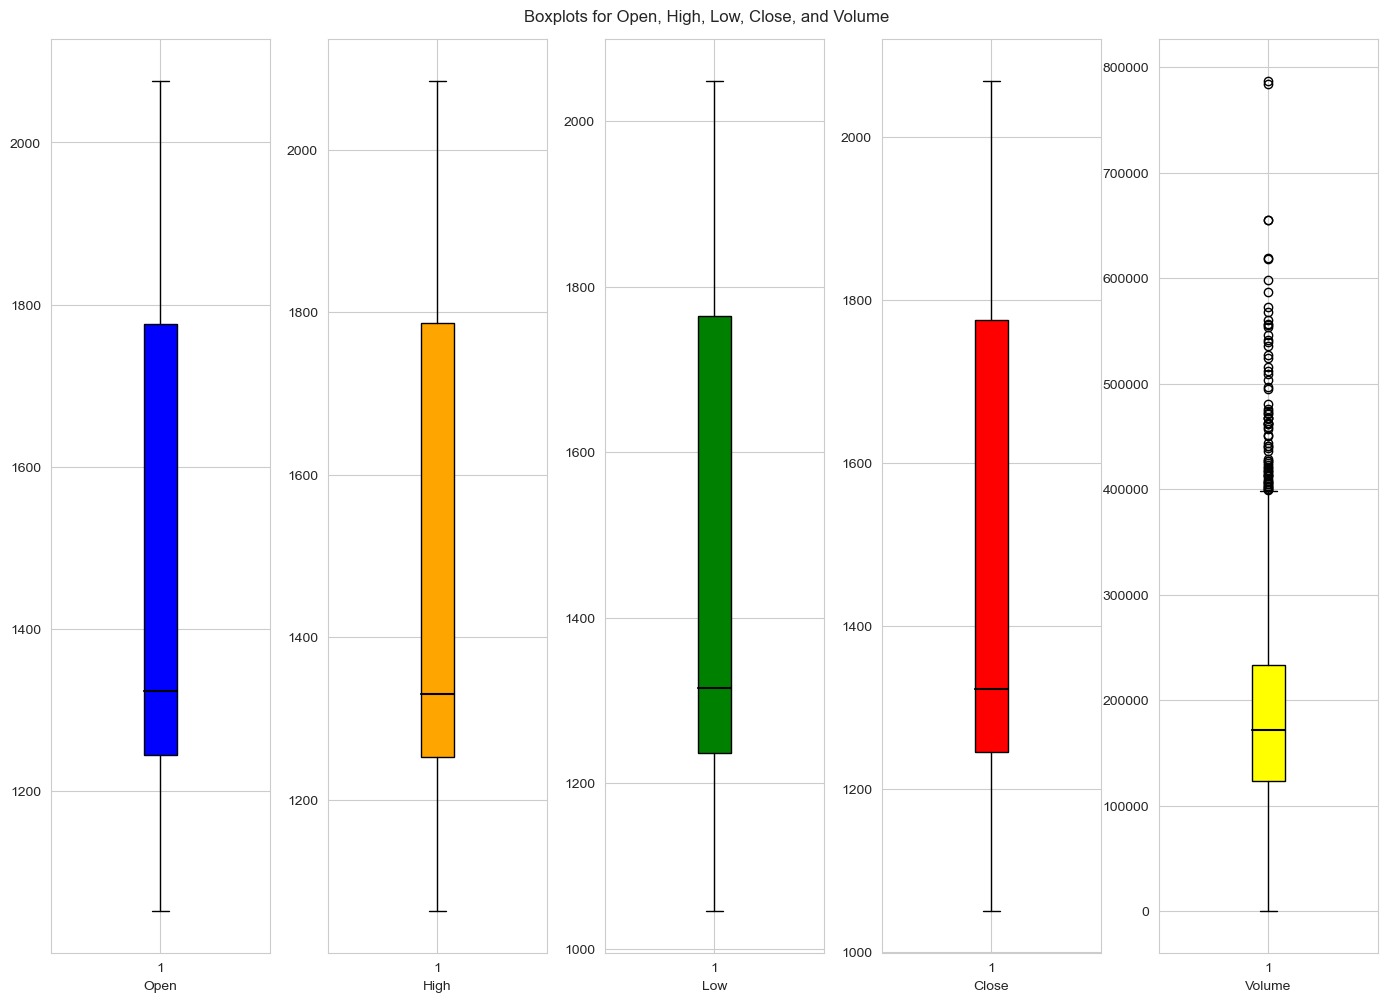

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(14, 10))
fig.suptitle('Boxplots for Open, High, Low, Close, and Volume')
fig.tight_layout()
ax1.boxplot(x=df['Open'],patch_artist = True,boxprops = dict(facecolor = "blue"),medianprops = dict(color = "black", 
                                                                                                    linewidth = 1.5))
ax1.set_xlabel('Open')
ax2.boxplot(x=df['High'],patch_artist = True,boxprops = dict(facecolor = "orange"),medianprops = dict(color = "black", 
                                                                                                      linewidth = 1.5))
ax2.set_xlabel('High')
ax3.boxplot(x=df['Low'],patch_artist = True,boxprops = dict(facecolor = "green"),medianprops = dict(color = "black", 
                                                                                                    linewidth = 1.5))
ax3.set_xlabel('Low')
ax4.boxplot(x=df['Close'],patch_artist = True,boxprops = dict(facecolor = "red"),medianprops = dict(color = "black", 
                                                                                                    linewidth = 1.5))
ax4.set_xlabel('Close')
ax5.boxplot(x=df['Volume'],patch_artist = True,boxprops = dict(facecolor = "yellow"),medianprops = dict(color = "black", 
                                                                                                        linewidth = 1.5))
ax5.set_xlabel('Volume');

The "Open", "High", "Low", and "Close" boxplots demonstrate they don't have any outliers. The "Volume" variable, however, has a good number of outliers.

In [16]:
df['MA300'] = df['Close'].rolling(300).mean()

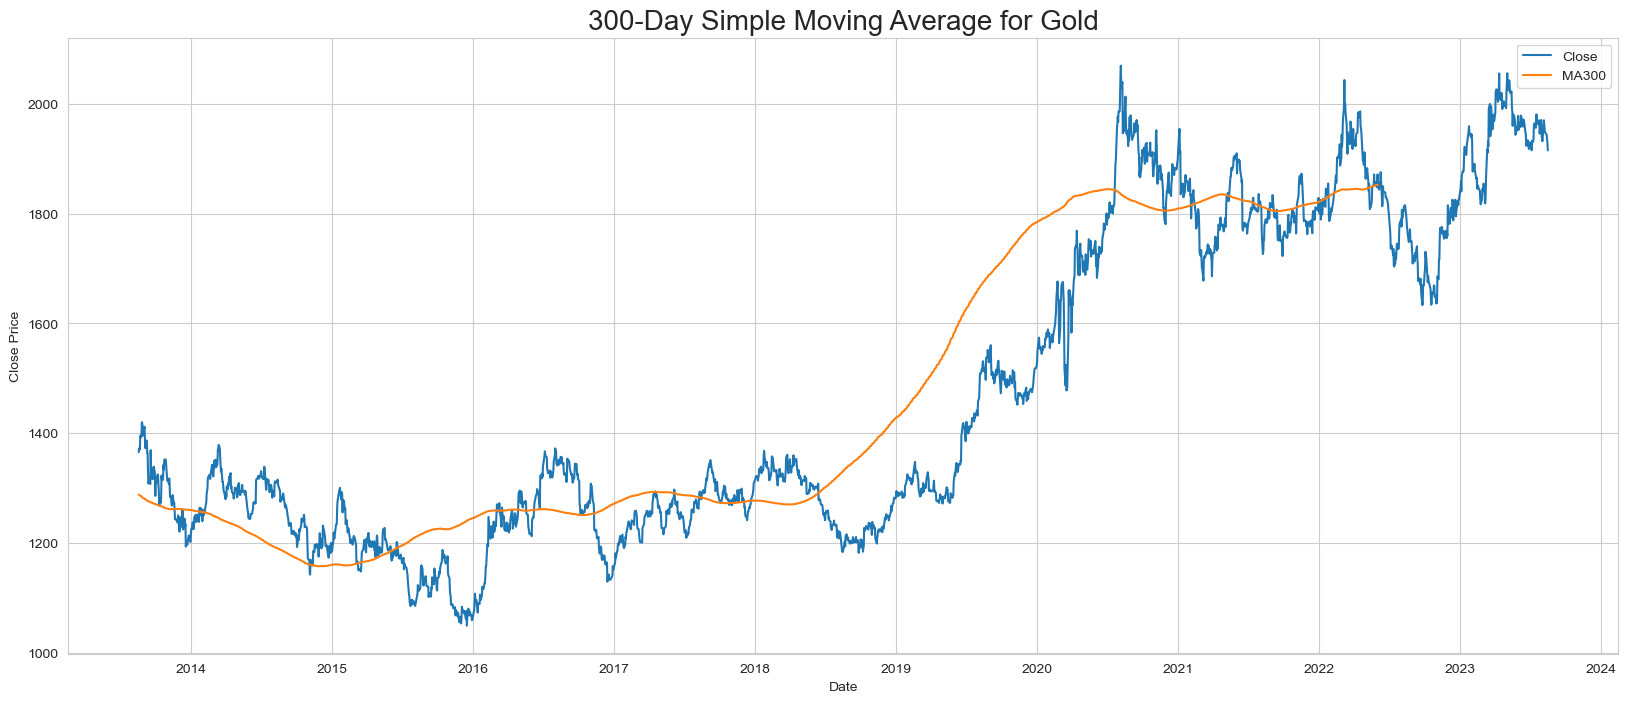

In [17]:
plt.figure(figsize=(20,8))
plt.plot('Date','Close',data=df)
plt.plot('Date','MA300',data=df,label='MA300')
plt.title('300-Day Simple Moving Average for Gold', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend();

Simple Moving Averages smooth the price data of any instrument to form a trend following indicator. It is done by calculating the average price of an instrument over a specific number of periods. Usually the Simple Moving Average is based on the closing price. (https://skilling.com/row/en/blog/trading-articles/what-are-moving-averages/) Based on the plot, gold is in an uptrend.

Now is the time to take a look at the daily returns of gold. A return in its simplest terms, is the money made or lost on an investment over some period of time. In this case, the daily return demonstrates the return obtained in a day after the gold price closes. The daily returns is calculated using the following formula:

\begin{align}
R_{t} = \frac{I_{t}}{I_{t-1}} - 1
\end{align}

In this formula, $I_{t}$ is the closing price. $I_{t-1}$ is the daily lag. The daily lag is shifting the close price by one day back.

In [18]:
df['Daily_Lag'] = df['Close'].shift(1)
df.head()

,Date,Close,Volume,Open,High,Low,MA300,Daily_Lag
0,2023-08-17,1915.2,146770.0,1922.4,1933.5,1914.2,NaN,NaN
1,2023-08-16,1928.3,124766.0,1933.1,1938.2,1922.0,NaN,1915.2
2,2023-08-15,1935.2,161512.0,1939.4,1944.3,1927.5,NaN,1928.3
3,2023-08-14,1944.0,117514.0,1945.6,1948.2,1934.2,NaN,1935.2
4,2023-08-11,1946.6,119090.0,1944.9,1953.6,1942.7,NaN,1944.0


It is necessary to create the "Daily_Lag" column in order to create the "Daily_Returns" column.

In [19]:
df['Daily_Returns'] = (df['Close']/df['Daily_Lag']) - 1
df.head()

,Date,Close,Volume,Open,High,Low,MA300,Daily_Lag,Daily_Returns
0,2023-08-17,1915.2,146770.0,1922.4,1933.5,1914.2,NaN,NaN,NaN
1,2023-08-16,1928.3,124766.0,1933.1,1938.2,1922.0,NaN,1915.2,0.006840
2,2023-08-15,1935.2,161512.0,1939.4,1944.3,1927.5,NaN,1928.3,0.003578
3,2023-08-14,1944.0,117514.0,1945.6,1948.2,1934.2,NaN,1935.2,0.004547
4,2023-08-11,1946.6,119090.0,1944.9,1953.6,1942.7,NaN,1944.0,0.001337


Now that the "Daily_Returns" column has been created, it is time to take a closer look into this variable and see what information can be gathered from it.

In [20]:
mean = df['Daily_Returns'].mean()
std = df['Daily_Returns'].std()
print('Mean =',mean)
print('Standard Deviation =',std)

Mean = -8.93942188670936e-05
Standard Deviation = 0.009523609112333591


The numbers above demonstrate that, in gerenal, if someone buys gold and sells it on the same day, they will make a loss. Normally returns are negative but this only reviews the returns on a day-to-day basis.

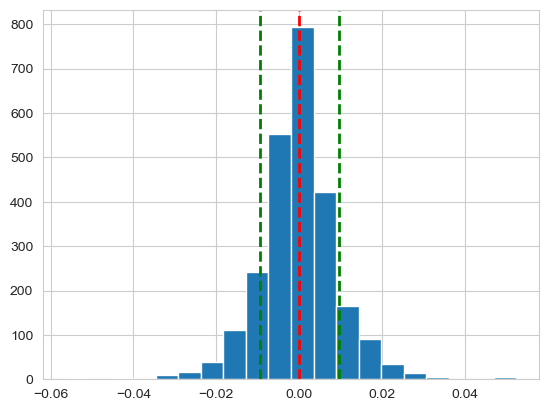

In [21]:
df['Daily_Returns'].hist(bins=20)
plt.axvline(mean,color='red',linestyle='dashed',linewidth=2)
plt.axvline(std,color='green',linestyle='dashed',linewidth=2)
plt.axvline(-std,color='green',linestyle='dashed',linewidth=2);

Since the standard deviation close to zero, this indicates that data points are very close to the mean. The histogram demonstrates how small the standard deviation is. 

In [22]:
df['Daily_Returns'].kurtosis()

3.629358379332053

Kurtosis is used to tell the "fatness" of a tail and how extreme the values can get. In this case the kurtosis value is positive, indicating that the chance of extreme values is rare.

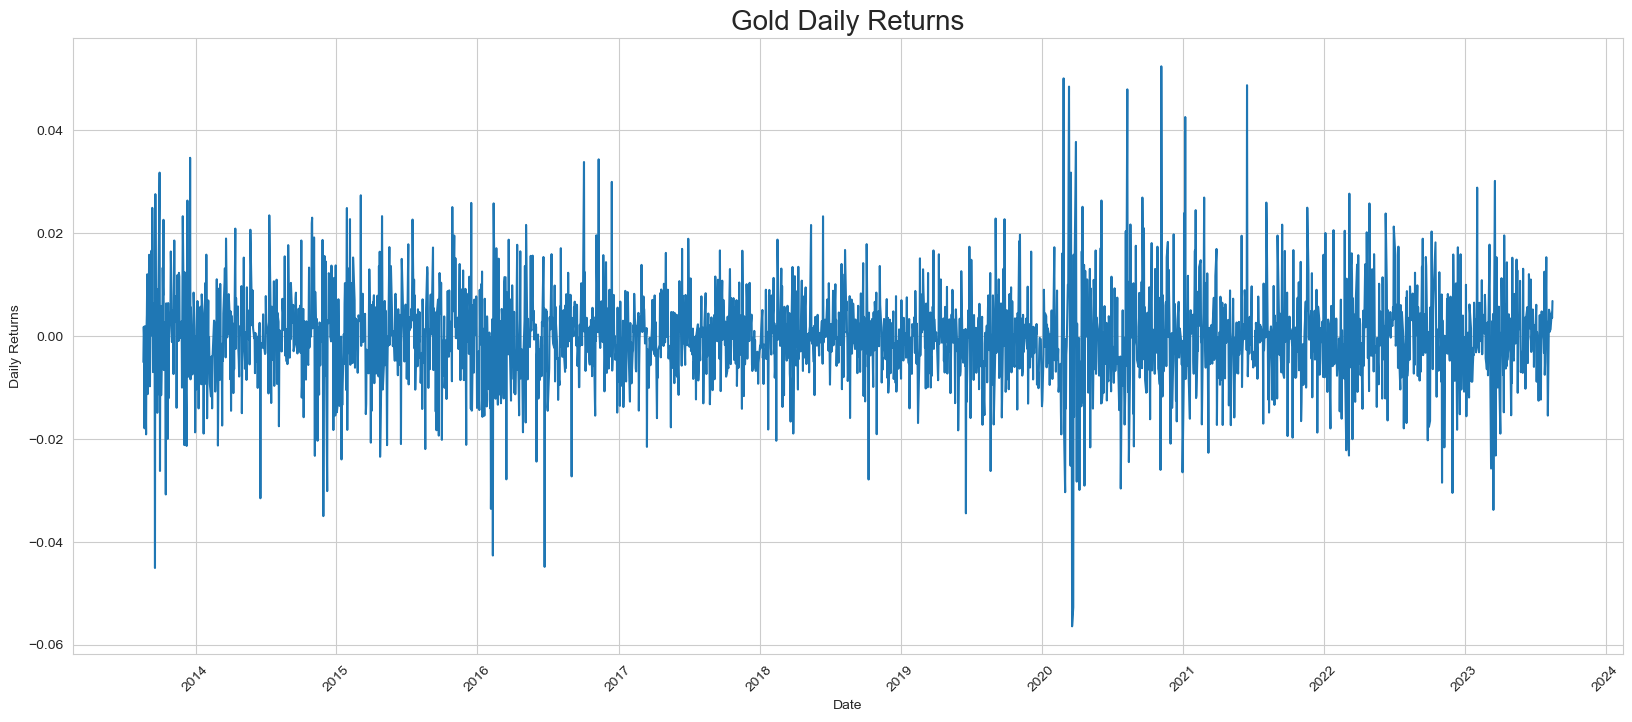

In [23]:
plt.figure(figsize=(20,8))
plt.plot('Date','Daily_Returns',data=df)
plt.title('Gold Daily Returns', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.xticks(rotation=45);

The daily returns plot demonstrates that the worst daily return for gold was in early 2020 with a daily return of a little over -5%. It can also be seen that the best day for gold was in late 2020 with around 5% daily return.

The cumulative return, sometimes referred to as the total return, is the total change in the investment price over a set time. This is an aggregate return, not an annualized one. The cumulative return can be calculated using the following formula:

\begin{align}
Cumulative Return = (1+R_{t})cumprod - 1
\end{align}

In [24]:
df['Cumulative_Return'] = (1 + df.Daily_Returns).cumprod() - 1

In [25]:
df

,Date,Close,Volume,Open,High,Low,MA300,Daily_Lag,Daily_Returns,Cumulative_Return
0,2023-08-17,1915.2,146770.0,1922.4,1933.5,1914.2,NaN,NaN,NaN,NaN
1,2023-08-16,1928.3,124766.0,1933.1,1938.2,1922.0,NaN,1915.2,0.006840,0.006840
2,2023-08-15,1935.2,161512.0,1939.4,1944.3,1927.5,NaN,1928.3,0.003578,0.010443
3,2023-08-14,1944.0,117514.0,1945.6,1948.2,1934.2,NaN,1935.2,0.004547,0.015038
4,2023-08-11,1946.6,119090.0,1944.9,1953.6,1942.7,NaN,1944.0,0.001337,0.016395
...,...,...,...,...,...,...,...,...,...,...
2506,2013-08-23,1395.8,149116.0,1376.1,1399.9,1367.8,1286.158000,1393.1,0.001938,-0.271199
2507,2013-08-22,1370.8,134493.0,1365.6,1381.4,1354.5,1286.822000,1395.8,-0.017911,-0.284252
2508,2013-08-21,1370.1,137350.0,1371.0,1378.9,1359.2,1287.393667,1370.8,-0.000511,-0.284618
2509,2013-08-20,1372.6,130096.0,1364.9,1378.0,1351.6,1287.886000,1370.1,0.001825,-0.283312


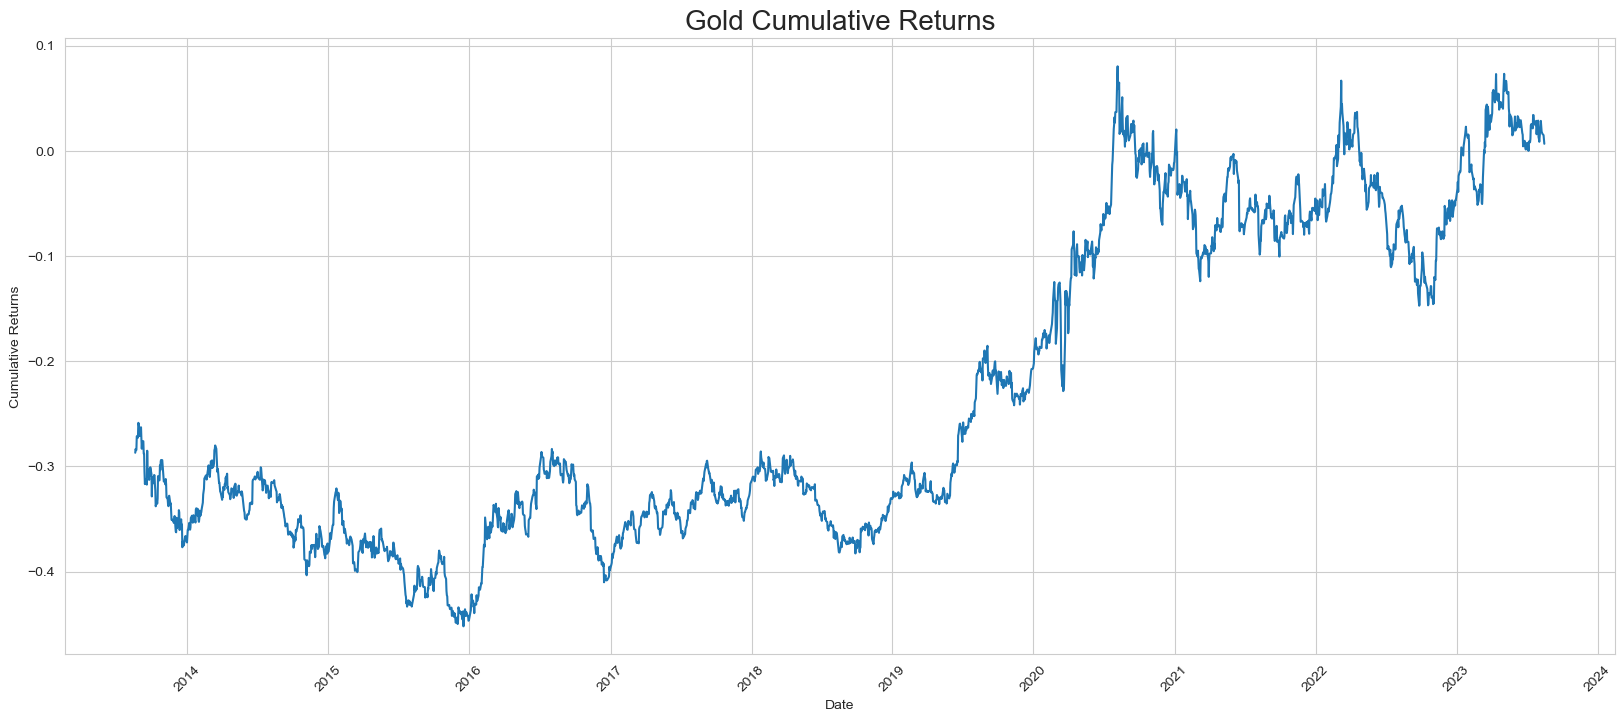

In [26]:
plt.figure(figsize=(20,8))
plt.plot('Date','Cumulative_Return',data=df)
plt.title('Gold Cumulative Returns', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.xticks(rotation=45);

Looking at the plot, it can be seen that there is a upward trend in gold cumulative returns.

In [27]:
df['Month'] = df['Date'].dt.month
df['Quarter_End'] = np.where(df['Month']%3==0,1,0)
df.head()

,Date,Close,Volume,Open,High,Low,MA300,Daily_Lag,Daily_Returns,Cumulative_Return,Month,Quarter_End
0,2023-08-17,1915.2,146770.0,1922.4,1933.5,1914.2,NaN,NaN,NaN,NaN,8,0
1,2023-08-16,1928.3,124766.0,1933.1,1938.2,1922.0,NaN,1915.2,0.006840,0.006840,8,0
2,2023-08-15,1935.2,161512.0,1939.4,1944.3,1927.5,NaN,1928.3,0.003578,0.010443,8,0
3,2023-08-14,1944.0,117514.0,1945.6,1948.2,1934.2,NaN,1935.2,0.004547,0.015038,8,0
4,2023-08-11,1946.6,119090.0,1944.9,1953.6,1942.7,NaN,1944.0,0.001337,0.016395,8,0


It’s hard to spot any link between the earning seasons and gold prices, but the "Quarter_End" variable will still be created to see if it has any impact in the predicting models. It’s not easy to determine the particular effect, as the correlation between the stock market and the precious metals market is constantly changing.

In [28]:
df.groupby('Quarter_End').mean()

,Close,Volume,Open,High,Low,MA300,Daily_Lag,Daily_Returns,Cumulative_Return,Month
Quarter_End,,,,,,,,,,
0,1472.148645,185715.752559,1472.079831,1481.521011,1462.448585,1452.418354,1472.297470,-0.000227,-0.231474,6.085491
1,1464.098706,179953.854118,1464.295765,1474.455059,1453.760471,1450.248836,1463.933294,0.000180,-0.235537,7.440000


The grouped data demonstrates that prices are lower in the months which are quarter end compared to that of the non-quarter end months. The volume of trades is lower in the months which are quarter end.

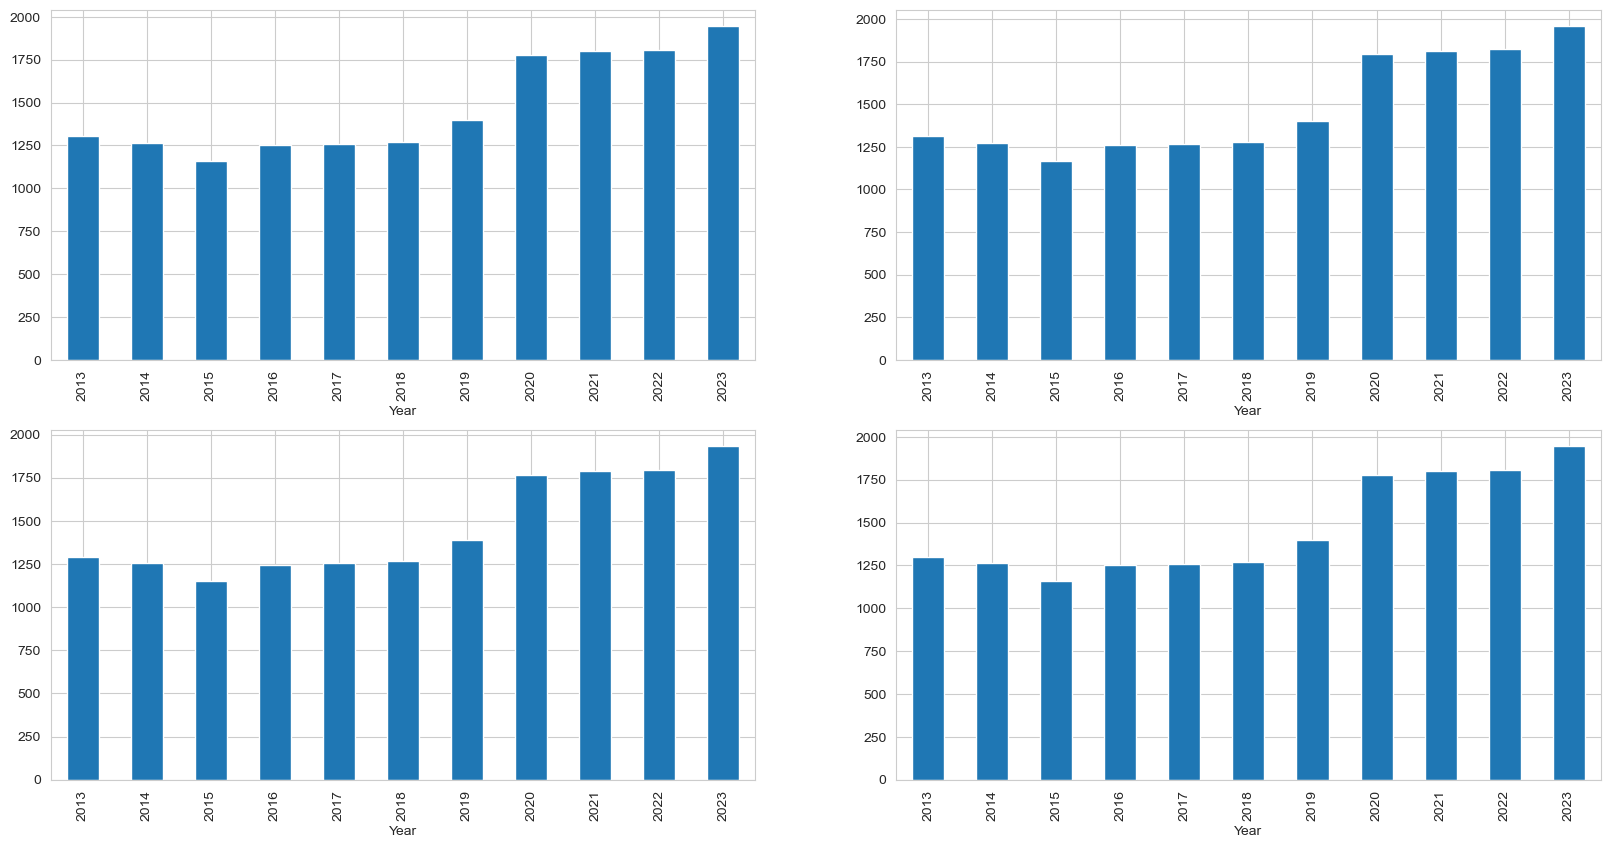

In [29]:
df['Year'] = df['Date'].dt.year
data_grouped = df.groupby('Year').mean()
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

The bar graph demonstrates that the price of gold increased significantly from 2019 to 2020. The price remained to be relatively steady in 2021 and 2022, but has slightly increased in 2023.

In [30]:
df['Open-High'] = df['Open'] - df['High']
df['Open-Low'] = df['Open'] - df['Low']
df['Open-Close'] = df['Open'] - df['Close']
df['Close-High'] = df['Close'] - df['High']
df['Close-Low'] = df['Close'] - df['Low']
df['High-Low'] = df['High'] - df['Low']
df['Low-High'] = df['Low'] - df['High']
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df.head()

,Date,Close,Volume,Open,High,Low,MA300,Daily_Lag,Daily_Returns,Cumulative_Return,...,Quarter_End,Year,Open-High,Open-Low,Open-Close,Close-High,Close-Low,High-Low,Low-High,Target
0,2023-08-17,1915.2,146770.0,1922.4,1933.5,1914.2,NaN,NaN,NaN,NaN,...,0,2023,-11.1,8.2,7.2,-18.3,1.0,19.3,-19.3,1
1,2023-08-16,1928.3,124766.0,1933.1,1938.2,1922.0,NaN,1915.2,0.006840,0.006840,...,0,2023,-5.1,11.1,4.8,-9.9,6.3,16.2,-16.2,1
2,2023-08-15,1935.2,161512.0,1939.4,1944.3,1927.5,NaN,1928.3,0.003578,0.010443,...,0,2023,-4.9,11.9,4.2,-9.1,7.7,16.8,-16.8,1
3,2023-08-14,1944.0,117514.0,1945.6,1948.2,1934.2,NaN,1935.2,0.004547,0.015038,...,0,2023,-2.6,11.4,1.6,-4.2,9.8,14.0,-14.0,1
4,2023-08-11,1946.6,119090.0,1944.9,1953.6,1942.7,NaN,1944.0,0.001337,0.016395,...,0,2023,-8.7,2.2,-1.7,-7.0,3.9,10.9,-10.9,1


Creating the "Open-High", "Open-Low", "Open-Close", "Close-High", "Close-Low", "High-Low", and "Low-High" columns to have them help in the training of the models. The "Target" column is a signal whether to buy or not.

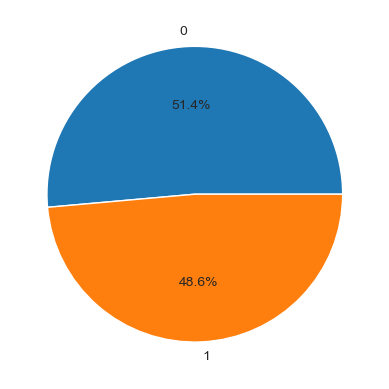

In [31]:
plt.pie(df['Target'].value_counts().values,labels=[0, 1],autopct='%1.1f%%')
plt.show()

Checking to see whether or not the "Target" column is balanced. The pie chart demonstrates that there are a little more 0 values than 1 values. This isn't concerning so it will remain in the dataset.

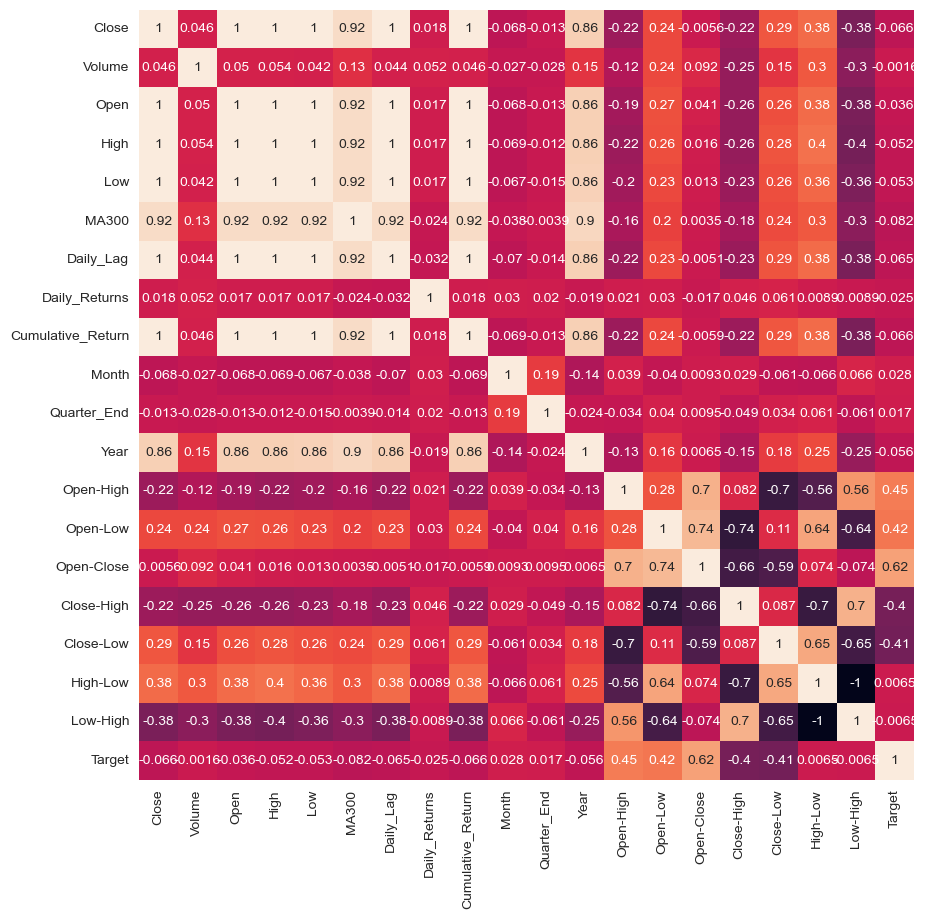

In [32]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cbar=False)
plt.show()

The heatmap generates a color-coded matrix that demonstrates how correlated two variables are with one another. The purpose of this heatmap is to see which variables will be used in the machine learning models. Highly correlated variables are the biggest concern for this project.

## Creating and Fitting Models

Three models will be created and fitted to predict a signal that indicates whether to buy gold or not. These three models will be compared with one another and the best model will be selected based on their performance.

In [33]:
features = df[['Open-High','Open-Low','Open-Close','Close-High','Close-Low','High-Low','Low-High','Quarter_End']]
target = df['Target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=101)

The features are the "Open-High", "Open-Low", "Open-Close", "Close-High", "Close-Low", "High-Low", "Low-High", "Quarter_End" variables from the dataset. Since the features differ greatly between their ranges, StandardScaler will be used to remove the mean and scale the data to the unit variance. The "Target" variable is a signal whether to buy gold or not and the models will be used to predict this only.

In [34]:
# RandomForestClassifier
n_estimators = np.arange(50, 350, 50).tolist()
max_features= [2,3,4]
bootstrap = [True,False]
oob_score = [True,False]

param_grid_rfc = {'n_estimators':n_estimators,'max_features':max_features,'bootstrap':bootstrap,'oob_score':oob_score}

# LogisticRegression
solver = ['lbfgs','liblinear', 'newton-cg','newton-cholesky','sag','saga']
penalty = ['l1','l2','elasticnet','none']
lr_C = [0.001,0.01,0.1,1,10,100,1000]

param_grid_lr = {'solver':solver,'penalty':penalty,'C':lr_C}

# SVC
svc_C = [0.001,0.01,0.1,1,10,100,1000]
gamma = [1,0.1,0.01,0.001,0.0001]
kernel = ['linear','poly','rbf','sigmoid']

param_grid_svc = {'C':svc_C,'gamma':gamma,'kernel':kernel} 

RandomForestClassifier, LogisticRegression, and SVC are the three machine learning models that will be used. To ensure these models are performing their best predictions, GridSearchCV will be used to perform hyper-parameter optimization. This method will try out different values and then pick the value that gives the best score for each model.

### RandomForestClassifier Grid Search

In [35]:
grid_rfc = GridSearchCV(RandomForestClassifier(),param_grid_rfc)

In [36]:
grid_rfc.fit(X_train,Y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_features': [2, 3, 4],
                         'n_estimators': [50, 100, 150, 200, 250, 300],
                         'oob_score': [True, False]})

In [37]:
grid_rfc.best_params_

{'bootstrap': True, 'max_features': 2, 'n_estimators': 50, 'oob_score': True}

### LogisticRegression Grid Search

In [38]:
grid_lr = GridSearchCV(LogisticRegression(),param_grid_lr)

In [39]:
grid_lr.fit(X_train,Y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']})

In [40]:
grid_lr.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

### SVC Grid Search

In [41]:
grid_svc = GridSearchCV(SVC(),param_grid_svc)

In [42]:
grid_svc.fit(X_train,Y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [43]:
grid_svc.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

### Comparing the Models

Now that the optimal parameters have been configured for each model, it is time to compare their accuracies with one another and select the best performing model.

In [44]:
models = [RandomForestClassifier(bootstrap= grid_rfc.best_params_['bootstrap'], 
                                 max_features= grid_rfc.best_params_['max_features'], 
                                 n_estimators= grid_rfc.best_params_['n_estimators'], 
                                 oob_score= grid_rfc.best_params_['oob_score']), 
          LogisticRegression(C= grid_lr.best_params_['C'], 
                             penalty= grid_lr.best_params_['penalty'], 
                             solver= grid_lr.best_params_['solver']), 
          SVC(C = grid_svc.best_params_['C'], 
              gamma = grid_svc.best_params_['gamma'], 
              kernel = grid_svc.best_params_['kernel'], 
              probability=True)]
 
val_score_list = []
for i in range(3):
  models[i].fit(X_train, Y_train)
  val_score_list.append(metrics.roc_auc_score(Y_test, models[i].predict_proba(X_test)[:,1]))

  print(f'{models[i]}')
  print('Training Accuracy:', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy:', metrics.roc_auc_score(Y_test, models[i].predict_proba(X_test)[:,1]))
  print()

RandomForestClassifier(max_features=2, n_estimators=50, oob_score=True)
Training Accuracy: 0.9999995038796611
Validation Accuracy: 0.9076843446408663

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
Training Accuracy: 0.942055625012403
Validation Accuracy: 0.9190157668418538

SVC(C=100, gamma=0.001, probability=True)
Training Accuracy: 0.9424594669683078
Validation Accuracy: 0.9184424271380793



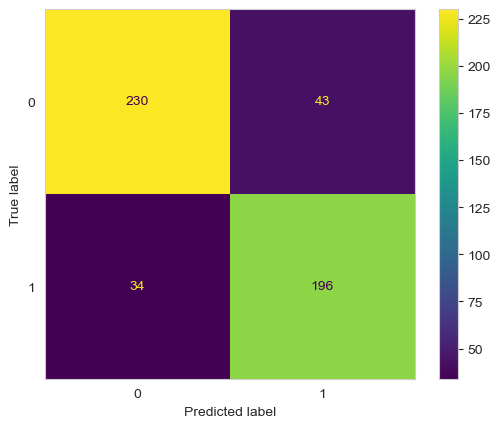

In [45]:
sns.set_style("whitegrid", {'axes.grid' : False})
metrics.plot_confusion_matrix(models[val_score_list.index(max(val_score_list))], X_test, Y_test)
plt.show()

The validation accuracy is based on data that the model hasn't been trained with, and thus a better indicator of how the model will perform with new data. Out of all the three models, the Logistic Regression model has the highest validation accuracy. This means that the Logistic Regression model is the best model for predicting a signal that indicates whether gold will be profitable or not.

